# Lab 2: Linear Regression and Model Selection

In [2]:
import pandas as pd
import numpy as np
from pandas.core.interchange.dataframe_protocol import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score

## Klasa do walidacji danych

In [3]:
class DataValidator:
    @staticmethod
    def validate_data(data) -> None:
        """Sprawdza poprawność danych wejściowych"""
        # Sprawdzanie braków danych
        missing = data.isnull().sum()
        if missing.any():
            print("Ostrzeżenie: Znaleziono brakujące wartości:")
            print(missing[missing > 0])

        # Sprawdzanie wartości odstających (outliers)
        z_scores = np.abs((data - data.mean()) / data.std())
        outliers = (z_scores > 3).sum()
        if outliers.any():
            print("\nOstrzeżenie: Znaleziono potencjalne wartości odstające:")
            print(outliers[outliers > 0])

        # Sprawdzanie zakresów wartości
        range_checks = {
            'Pct.BF': (0, 100),  # procent tłuszczu między 0-100%
            'Age': (0, 120),  # wiek między 0-120 lat
            'Weight': (30, 300),  # waga między 30-300 kg/pounds
            'Height': (120, 220),  # wzrost między 120-220 cm
        }

        for column, (min_val, max_val) in range_checks.items():
            if column in data.columns:
                invalid = data[(data[column] < min_val) | (data[column] > max_val)]
                if not invalid.empty:
                    print(f"\nOstrzeżenie: Znaleziono wartości poza zakresem dla {column}:")
                    print(f"Min: {data[column].min()}, Max: {data[column].max()}")

        # Sprawdzanie korelacji
        correlations = data.corr()
        high_corr = (np.abs(correlations) > 0.9) & (np.abs(correlations) < 1.0)
        if high_corr.any().any():
            print("\nOstrzeżenie: Znaleziono silnie skorelowane zmienne:")
            for col in correlations.columns:
                highly_corr = correlations[col][high_corr[col]].index.tolist()
                if highly_corr:
                    print(f"{col} jest silnie skorelowane z: {highly_corr}")


## Wczytanie danych

In [4]:
def load_data_from_document(doc_content) -> pd.DataFrame:
    """Wczytuje dane z dokumentu i przeprowadza podstawową walidację"""
    # Definiujemy nazwy kolumn
    columns = ['Density', 'Pct.BF', 'Age', 'Weight', 'Height', 'Neck', 'Chest', 'Abdomen', 'Waist',
               'Hip', 'Thigh', 'Knee', 'Ankle', 'Bicep', 'Forearm', 'Wrist']

    # Wczytujemy linie z dokumentu, pomijając nagłówek
    lines = doc_content.strip().split('\n')
    data = []

    for line in lines:
        if line and not line.startswith('Density'):
            try:
                # Próbujemy przekonwertować wartości na liczby
                values = [float(x) for x in line.split()]
                if len(values) == len(columns):
                    data.append(values)
                else:
                    print(f"Ostrzeżenie: Pominięto linię z nieprawidłową liczbą kolumn: {line}")
            except ValueError as e:
                print(f"Ostrzeżenie: Pominięto linię z nieprawidłowymi danymi: {line}")
                print(f"Błąd: {e}")

    # Tworzymy DataFrame
    df = pd.DataFrame(data, columns=columns)

    # Przeprowadzamy walidację
    validator = DataValidator()
    validator.validate_data(df)

    return df

## Analizowanie korelacji


Correlations with Pct.BF:
Pct.BF     1.000000
Waist      0.823685
Abdomen    0.823685
Chest      0.700670
Hip        0.632675
Weight     0.617299
Thigh      0.548550
Knee       0.492308
Neck       0.488524
Bicep      0.481538
Forearm    0.364709
Wrist      0.339008
Age        0.295051
Ankle      0.244556
Height    -0.029390
Density   -0.987480
Name: Pct.BF, dtype: float64


C:\Users\szyme\AppData\Local\Temp\ipykernel_45804\1783352203.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(r"C:\Users\szyme\PycharmProjects\MED\MED_LAB_1\data\dane.txt", delim_whitespace=True)


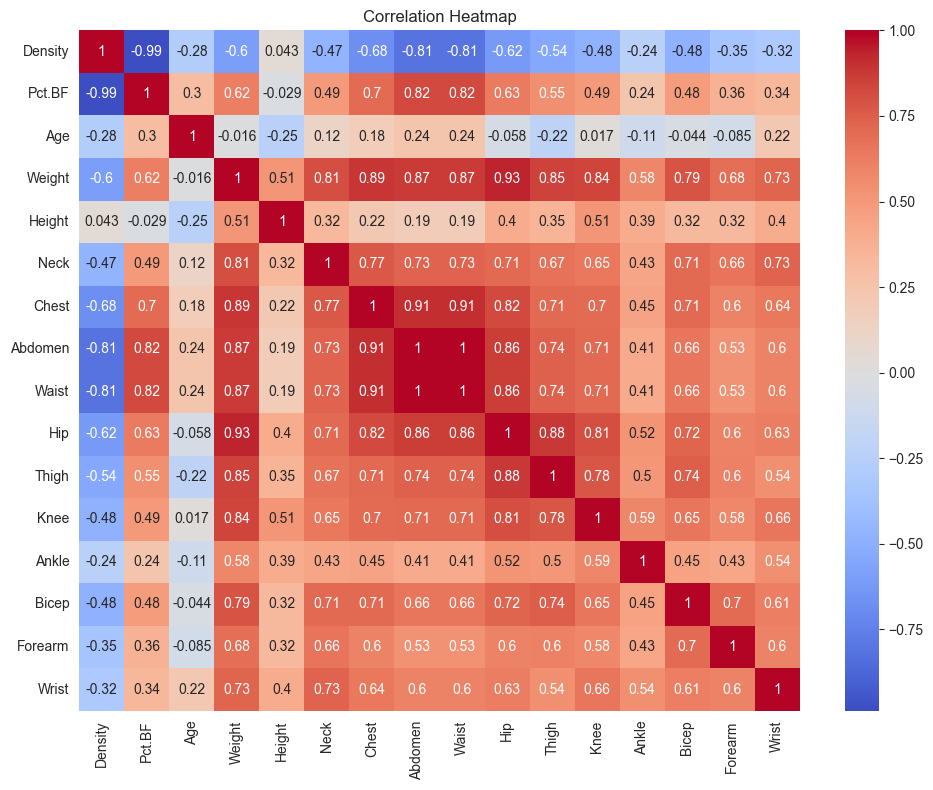

In [5]:
def analyze_correlations(df, target='Pct.BF') -> pd.Series:
    """Analyze correlations with target variable"""
    correlations = df.corr()[target].sort_values(ascending=False)
    print(f"\nCorrelations with {target}:")
    print(correlations)


    # Create correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()

    return correlations

try:
    # Wersja z pandas - jeśli dane są w formacie csv
    data = pd.read_csv(r"C:\Users\szyme\PycharmProjects\MED\MED_LAB_1\data\dane.txt", delim_whitespace=True)
    correlations = analyze_correlations(data)
    
except FileNotFoundError:
    print("Błąd: Nie znaleziono pliku z danymi!")
except pd.errors.EmptyDataError:
    print("Błąd: Plik z danymi jest pusty!")
except Exception as e:
    print(f"Wystąpił nieoczekiwany błąd: {e}")

## Backward Elimination, Forward Selection, Stepwise Selection

In [6]:
class StepwiseSelector:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.features = list(X.columns)

    
    def _calculate_pvalues(self, X, y) -> (pd.Series, float):
        """Oblicza p-wartości dla zmiennych w modelu"""
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        # print(model.summary())
        # print(model.pvalues)
        return model.pvalues[1:], model.rsquared
    
    def forward_selection(self, threshold=0.05) -> list:
        """Forward Selection"""
        selected = []
        remaining = self.features.copy()
        current_score = 0
    
        print("\nForward Selection:")
        print("------------------")
    
        while remaining and len(selected) < len(self.features):
            best_pval = 999
            best_feature = None
            best_score = current_score
    
            for feature in remaining:
                features_to_test = selected + [feature]
                X_test = self.X[features_to_test]
                pvalues, score = self._calculate_pvalues(X_test, self.y)
                pval = pvalues[feature]
    
                if pval < best_pval and score > best_score:
                    best_pval = pval
                    best_feature = feature
                    best_score = score
    
            if best_feature and best_pval < threshold:
                selected.append(best_feature)
                remaining.remove(best_feature)
                current_score = best_score
                print(f"Dodano: {best_feature} (p-value: {best_pval:.4f}, R²: {best_score:.4f})")
            else:
                break
    
        return selected
    
    def backward_elimination(self, threshold=0.05) -> list:
        """Backward Elimination"""
        selected = self.features.copy()
    
        print("\nBackward Elimination:")
        print("---------------------")
    
        while selected:
            pvalues, score = self._calculate_pvalues(self.X[selected], self.y)
            max_pval = pvalues.max()
            if max_pval > threshold:
                worst_feature = pvalues.idxmax()
                selected.remove(worst_feature)
                print(f"Usunięto: {worst_feature} (p-value: {max_pval:.4f}, R²: {score:.4f})")
            else:
                break
    
        return selected
    
    def stepwise_selection(self, threshold_in=0.05, threshold_out=0.05) -> list:
        """Stepwise Selection"""
        selected = []
        remaining = self.features.copy()
    
        print("\nStepwise Selection:")
        print("-------------------")
    
        while True:
            # Forward step
            best_pval = 999
            best_feature = None
            best_score = 0
    
            for feature in remaining:
                features_to_test = selected + [feature]
                X_test = self.X[features_to_test]
                pvalues, score = self._calculate_pvalues(X_test, self.y)
                pval = pvalues[feature]
    
                if pval < best_pval and pval < threshold_in:
                    best_pval = pval
                    best_feature = feature
                    best_score = score
    
            if best_feature:
                selected.append(best_feature)
                remaining.remove(best_feature)
                print(f"Dodano: {best_feature} (p-value: {best_pval:.4f}, R²: {best_score:.4f})")
    
                # Backward step
                while len(selected) > 1:
                    pvalues, score = self._calculate_pvalues(self.X[selected], self.y)
                    max_pval = pvalues.max()
                    if max_pval > threshold_out:
                        worst_feature = pvalues.idxmax()
                        selected.remove(worst_feature)
                        print(f"Usunięto: {worst_feature} (p-value: {max_pval:.4f}, R²: {score:.4f})")
                    else:
                        break
            else:
                break
    
        return selected
    
    def compare_methods(self) -> (DataFrame, dict):
        """Porównuje wyniki wszystkich trzech metod"""
        print("\nPorównanie metod selekcji zmiennych:")
        print("=====================================")
    
        forward = self.forward_selection()
        backward = self.backward_elimination()
        stepwise = self.stepwise_selection()
    
        results = pd.DataFrame({
            'Forward': [feature in forward for feature in self.features],
            'Backward': [feature in backward for feature in self.features],
            'Stepwise': [feature in stepwise for feature in self.features]
        }, index=self.features)
    
        print("\nWybrane zmienne przez każdą metodę:")
        print(results)
    
        # Ocena modeli
        models_r2 = {}
        for name, selected in [('Forward', forward), ('Backward', backward), ('Stepwise', stepwise)]:
            if selected:  # sprawdzamy czy lista nie jest pusta
                X_selected = self.X[selected]
                model = LinearRegression()
                model.fit(X_selected, self.y)
                r2 = r2_score(self.y, model.predict(X_selected))
                models_r2[name] = r2
            else:
                print(f"\nOstrzeżenie: Metoda {name} nie wybrała żadnych zmiennych!")
                models_r2[name] = 0
    
        print("\nWyniki modeli (R²):")
        for method, r2 in models_r2.items():
            print(f"{method}: {r2:.4f}")
    
        return results, models_r2

## Main Excecution

In [40]:
# Wczytanie danych z pliku
try:
    # Wersja z pandas - jeśli dane są w formacie csv
    data = pd.read_csv(r"C:\Users\szyme\PycharmProjects\MED\MED_LAB_1\data\dane.txt", delim_whitespace=True)

    print(f"\nWczytano dane o wymiarach: {data.shape}")

    # Wybór zmiennych do analizy
    # features = [col for col in data.columns if col not in ['Pct.BF', 'Density']]
    # features = [col for col in data.columns if col not in ['Pct.BF', 'Age', 'Weight', 'Height', 'Neck', 'Chest', 'Abdomen', 'Waist',
               # 'Hip', 'Thigh', 'Knee', 'Ankle', 'Bicep', 'Forearm', 'Wrist']]
    features = [col for col in data.columns if col not in ['Density', 'Pct.BF']]
    # features = [col for col in data.columns if col not in ['Weight']]
    X = data[features] # zmienna niezależna
    # y = data['Density'] # zmienna zależna
    
    # X = data[features]
    # y = data['Weight']
    y = data['Density']
    # y = data['Pct.BF']
    

    # Analiza
    selector = StepwiseSelector(X, y)
    results, scores = selector.compare_methods()
    # selector.collect_visualization_data()

except FileNotFoundError:
    print("Błąd: Nie znaleziono pliku z danymi!")
except pd.errors.EmptyDataError:
    print("Błąd: Plik z danymi jest pusty!")
except Exception as e:
    print(f"Wystąpił nieoczekiwany błąd: {e}")


Wczytano dane o wymiarach: (250, 16)

Porównanie metod selekcji zmiennych:

Forward Selection:
------------------
Dodano: Waist (p-value: 0.0000, R²: 0.6545)
Dodano: Weight (p-value: 0.0000, R²: 0.7043)
Dodano: Wrist (p-value: 0.0009, R²: 0.7174)
Dodano: Bicep (p-value: 0.0188, R²: 0.7237)

Backward Elimination:
---------------------
Usunięto: Knee (p-value: 0.9177, R²: 0.7389)
Usunięto: Abdomen (p-value: 0.7583, R²: 0.7389)
Usunięto: Weight (p-value: 0.5930, R²: 0.7387)
Usunięto: Ankle (p-value: 0.2359, R²: 0.7384)
Usunięto: Forearm (p-value: 0.1962, R²: 0.7369)
Usunięto: Thigh (p-value: 0.1513, R²: 0.7350)
Usunięto: Hip (p-value: 0.2831, R²: 0.7327)
Usunięto: Neck (p-value: 0.1329, R²: 0.7315)
Usunięto: Bicep (p-value: 0.0559, R²: 0.7289)
Usunięto: Age (p-value: 0.1017, R²: 0.7248)

Stepwise Selection:
-------------------
Dodano: Waist (p-value: 0.0000, R²: 0.6545)
Dodano: Weight (p-value: 0.0000, R²: 0.7043)
Dodano: Wrist (p-value: 0.0009, R²: 0.7174)
Dodano: Bicep (p-value: 0.0188

C:\Users\szyme\AppData\Local\Temp\ipykernel_45804\2554454876.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(r"C:\Users\szyme\PycharmProjects\MED\MED_LAB_1\data\dane.txt", delim_whitespace=True)


## Faktyczna wizualizacja regresji dla 2 zmiennych tylko bo wykres 3d!!!!

In [41]:
def visualize_regression_results(X, y, selected_features, model_name):
    model = LinearRegression()
    X_selected = X[selected_features]
    model.fit(X_selected, y)

    # Tworzymy siatkę punktów dla naszych zmiennych
    density_range = np.linspace(X['Density'].min(), X['Density'].max(), 100)
    abdomen_range = np.linspace(X['Abdomen'].min(), X['Abdomen'].max(), 100)

    # Tworzymy 3D plot - bo mamy równanie z dwiema zmiennymi!
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Tworzymy siatkę punktów
    D, A = np.meshgrid(density_range, abdomen_range)

    # Obliczamy wartości y dla każdego punktu siatki DOKŁADNIE z naszego równania
    Z = model.intercept_ + model.coef_[0]*D + model.coef_[1]*A

    # Rysujemy powierzchnię regresji
    surface = ax.plot_surface(D, A, Z, alpha=0.5)

    # Rysujemy rzeczywiste punkty
    ax.scatter(X['Density'], X['Abdomen'], y, c='red', marker='o')

    ax.set_xlabel('Density')
    ax.set_ylabel('Abdomen')
    ax.set_zlabel('y')

    # Dodajemy równanie
    equation = f'y = {model.intercept_:.4f} + ({model.coef_[0]:.4f} * Density) + ({model.coef_[1]:.4f} * Abdomen)'
    plt.title(f'Model regresji:\n{equation}')

    plt.show()

In [42]:
# Używamy dla każdej metody
selector = StepwiseSelector(X, y)

# Forward Selection
forward_features = selector.forward_selection()
visualize_regression_results(X, y, forward_features, "Forward Selection")

# Backward Elimination
backward_features = selector.backward_elimination()
visualize_regression_results(X, y, backward_features, "Backward Elimination")

# Stepwise Selection
stepwise_features = selector.stepwise_selection()
visualize_regression_results(X, y, stepwise_features, "Stepwise Selection")


Forward Selection:
------------------
Dodano: Waist (p-value: 0.0000, R²: 0.6545)
Dodano: Weight (p-value: 0.0000, R²: 0.7043)
Dodano: Wrist (p-value: 0.0009, R²: 0.7174)
Dodano: Bicep (p-value: 0.0188, R²: 0.7237)


KeyError: 'Density'

## Funkcja do wizualizacji wyników regresji dla zadanych metod eliminacji zmiennych uzywac do MAX 1 zmiennej

In [43]:
def visualize_regression_results(X, y, selected_features, model_name):
    """
    Visualize regression results based on number of features:
    - For 1 feature: 2D plot with regression line
    - For 2 features: 3D surface plot
    - For >2 features: Predicted vs Actual values plot
    """
    model = LinearRegression()
    X_selected = X[selected_features]
    model.fit(X_selected, y)
    y_pred = model.predict(X_selected)
    r2 = r2_score(y, y_pred)
    std_err = np.sqrt(mean_squared_error(y, y_pred))

    if len(selected_features) == 1:
        # Single feature case - 2D plot
        feature = selected_features[0]
        plt.figure(figsize=(12, 6))

        # Plot actual data points
        plt.scatter(X[feature], y, alpha=0.5, label='Dane rzeczywiste')

        # Create and plot regression line
        x_range = np.linspace(X[feature].min(), X[feature].max(), 100)
        y_range = model.intercept_ + model.coef_[0] * x_range
        plt.plot(x_range, y_range, 'r-', label='Model regresji', linewidth=2)

        # Add labels and title
        plt.xlabel(feature)
        plt.ylabel('Wartość docelowa')
        plt.title(f'Model {model_name}\nR² = {r2:.4f}, Błąd std. = {std_err:.4f}')

        # Add regression equation
        equation = f'y = {model.intercept_:.4f} + ({model.coef_[0]:.4f} * {feature})'
        plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top')

    elif len(selected_features) == 2:
        # Two features case - 3D plot
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Create mesh grid for surface plot
        x1_range = np.linspace(X[selected_features[0]].min(), X[selected_features[0]].max(), 100)
        x2_range = np.linspace(X[selected_features[1]].min(), X[selected_features[1]].max(), 100)
        X1, X2 = np.meshgrid(x1_range, x2_range)

        # Calculate predicted values for surface
        Z = model.intercept_ + model.coef_[0]*X1 + model.coef_[1]*X2

        # Plot surface and actual points
        surface = ax.plot_surface(X1, X2, Z, alpha=0.5)
        ax.scatter(X[selected_features[0]], X[selected_features[1]], y, c='red', marker='o')

        # Labels and title
        ax.set_xlabel(selected_features[0])
        ax.set_ylabel(selected_features[1])
        ax.set_zlabel('Wartość docelowa')

        equation = f'y = {model.intercept_:.4f} + ({model.coef_[0]:.4f} * {selected_features[0]}) + ({model.coef_[1]:.4f} * {selected_features[1]})'
        plt.title(f'Model {model_name}\n{equation}')

    else:
        # Multiple features case - Predicted vs Actual plot
        plt.figure(figsize=(12, 6))
        plt.scatter(y_pred, y, alpha=0.5, label='Dane rzeczywiste')
        plt.plot(np.sort(y_pred), np.sort(y_pred), 'r-', label='Model regresji', linewidth=2)

        plt.xlabel('Wartości przewidziane przez model')
        plt.ylabel('Wartości rzeczywiste')
        plt.title(f'Model {model_name}\nR² = {r2:.4f}, Błąd std. = {std_err:.4f}')

        equation = f'y = {model.intercept_:.4f}'
        for i, feature in enumerate(selected_features):
            equation += f' + ({model.coef_[i]:.4f} * {feature})'
        plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top')

    plt.legend()
    plt.grid(True)
    plt.show()


Forward Selection:
------------------
Dodano: Waist (p-value: 0.0000, R²: 0.6545)
Dodano: Weight (p-value: 0.0000, R²: 0.7043)
Dodano: Wrist (p-value: 0.0009, R²: 0.7174)
Dodano: Bicep (p-value: 0.0188, R²: 0.7237)


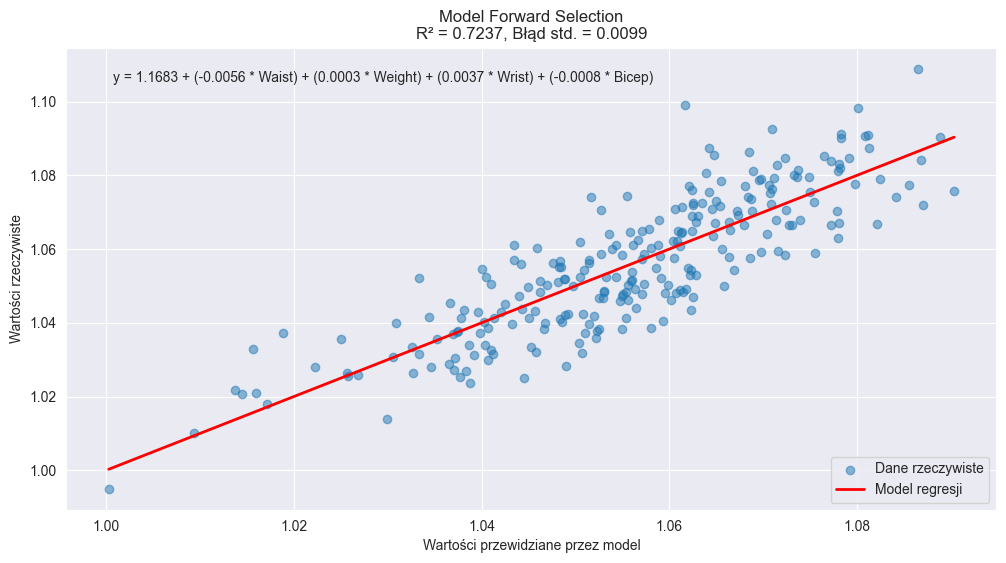


Backward Elimination:
---------------------
Usunięto: Knee (p-value: 0.9177, R²: 0.7389)
Usunięto: Abdomen (p-value: 0.7583, R²: 0.7389)
Usunięto: Weight (p-value: 0.5930, R²: 0.7387)
Usunięto: Ankle (p-value: 0.2359, R²: 0.7384)
Usunięto: Forearm (p-value: 0.1962, R²: 0.7369)
Usunięto: Thigh (p-value: 0.1513, R²: 0.7350)
Usunięto: Hip (p-value: 0.2831, R²: 0.7327)
Usunięto: Neck (p-value: 0.1329, R²: 0.7315)
Usunięto: Bicep (p-value: 0.0559, R²: 0.7289)
Usunięto: Age (p-value: 0.1017, R²: 0.7248)


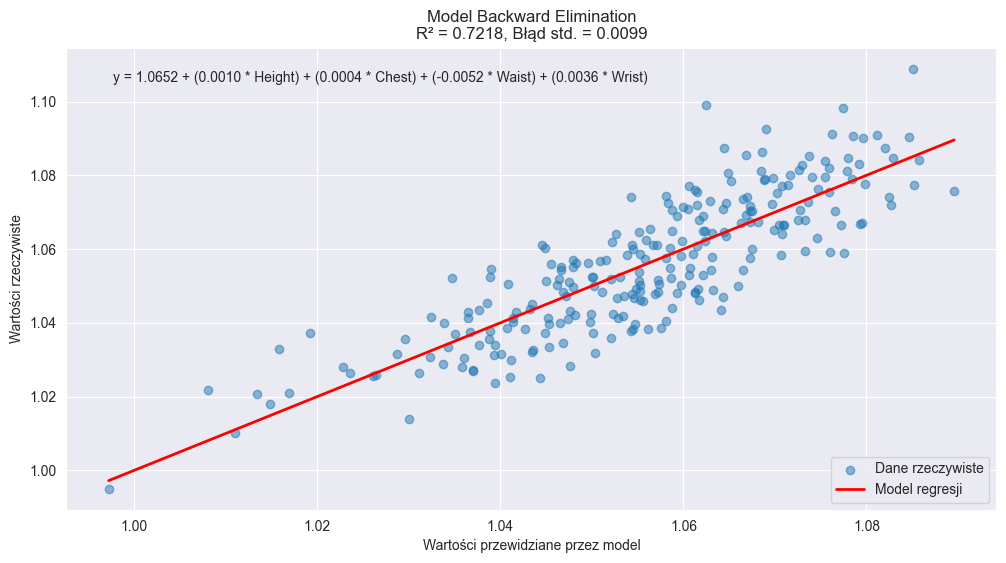


Stepwise Selection:
-------------------
Dodano: Waist (p-value: 0.0000, R²: 0.6545)
Dodano: Weight (p-value: 0.0000, R²: 0.7043)
Dodano: Wrist (p-value: 0.0009, R²: 0.7174)
Dodano: Bicep (p-value: 0.0188, R²: 0.7237)


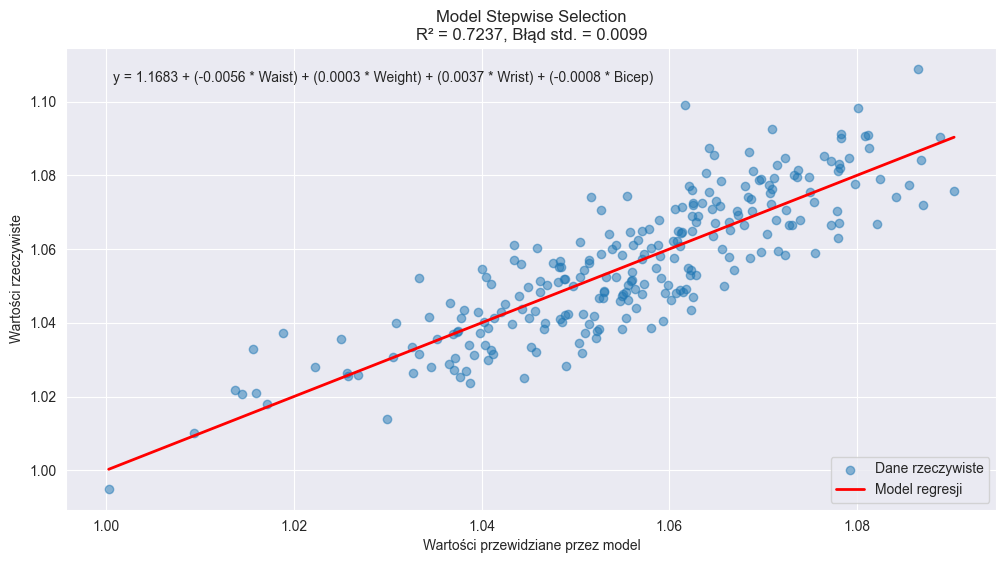

In [44]:
# Używamy dla każdej metody
selector = StepwiseSelector(X, y)

# Forward Selection
forward_features = selector.forward_selection()
visualize_regression_results(X, y, forward_features, "Forward Selection")

# Backward Elimination
backward_features = selector.backward_elimination()
visualize_regression_results(X, y, backward_features, "Backward Elimination")

# Stepwise Selection
stepwise_features = selector.stepwise_selection()
visualize_regression_results(X, y, stepwise_features, "Stepwise Selection")

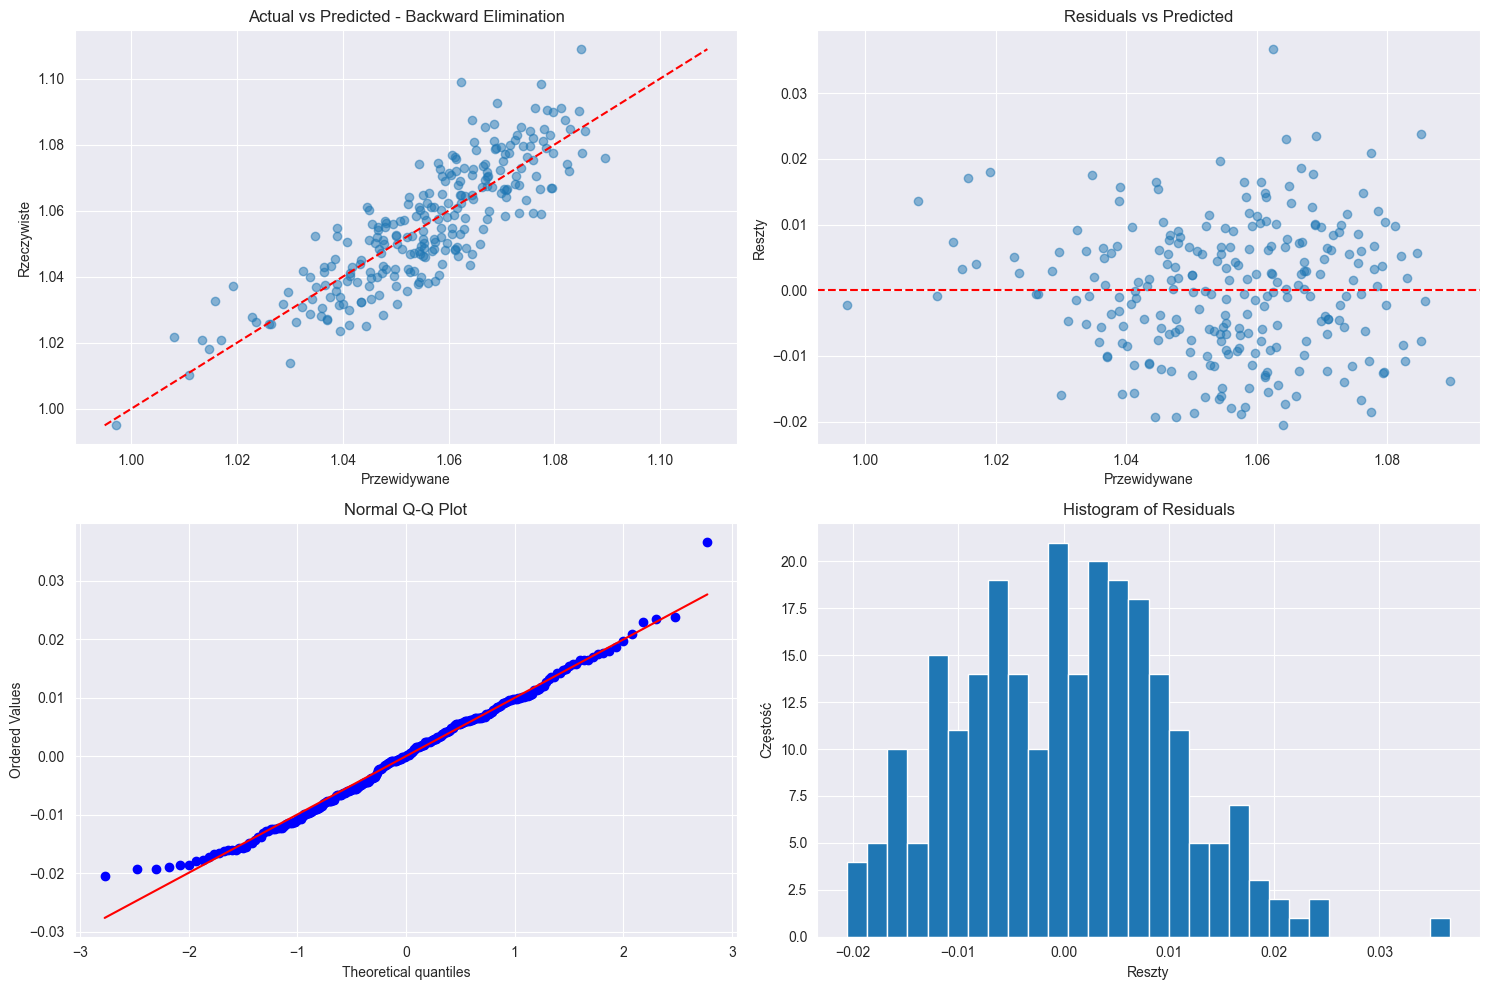


Statystyki dla modelu Backward Elimination:
R² = 0.7218
RMSE = 0.0099


In [49]:
def add_diagnostic_plots(X, y, model_name, selected_features):
    # Tworzymy i dopasowujemy model
    model = LinearRegression()
    model.fit(X[selected_features], y)
    
    # Reszty vs wartości przewidywane
    residuals = y - model.predict(X[selected_features])
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Predicted vs Actual (obecny wykres)
    axes[0,0].scatter(model.predict(X[selected_features]), y, alpha=0.5)
    axes[0,0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    axes[0,0].set_xlabel('Przewidywane')
    axes[0,0].set_ylabel('Rzeczywiste')
    axes[0,0].set_title(f'Actual vs Predicted - {model_name}')
    
    # 2. Residuals vs Predicted
    axes[0,1].scatter(model.predict(X[selected_features]), residuals, alpha=0.5)
    axes[0,1].axhline(y=0, color='r', linestyle='--')
    axes[0,1].set_xlabel('Przewidywane')
    axes[0,1].set_ylabel('Reszty')
    axes[0,1].set_title('Residuals vs Predicted')
    
    # 3. QQ Plot
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1,0])
    axes[1,0].set_title('Normal Q-Q Plot')
    
    # 4. Histogram reszt
    axes[1,1].hist(residuals, bins=30)
    axes[1,1].set_xlabel('Reszty')
    axes[1,1].set_ylabel('Częstość')
    axes[1,1].set_title('Histogram of Residuals')
    
    plt.tight_layout()
    plt.show()
    
    # Wydrukuj podstawowe statystyki
    print(f"\nStatystyki dla modelu {model_name}:")
    print(f"R² = {model.score(X[selected_features], y):.4f}")
    print(f"RMSE = {np.sqrt(mean_squared_error(y, model.predict(X[selected_features]))):.4f}")
    
add_diagnostic_plots(X, y, "Backward Elimination", backward_features)

## Test dla mnie zgodnosci liniowej regresji pokazuje dobrze dla 1 zmiennej

In [18]:
def visualize_regression_results(X, y, selected_features, model_name):
    """
    Wizualizacja wyników regresji z rozszerzonym zakresem wykresu, pokazującym
    teoretyczny punkt przecięcia z osią y (wyraz wolny b).
    """
    model = LinearRegression()
    X_selected = X[selected_features]
    model.fit(X_selected, y)
    y_pred = model.predict(X_selected)
    r2 = r2_score(y, y_pred)
    std_err = np.sqrt(mean_squared_error(y, y_pred))

    if len(selected_features) == 1:
        feature = selected_features[0]
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # Wykres 1: Standardowy zakres danych
        ax1.scatter(X[feature], y, alpha=0.5, label='Dane rzeczywiste')
        x_range = np.linspace(X[feature].min(), X[feature].max(), 100)
        y_range = model.intercept_ + model.coef_[0] * x_range
        ax1.plot(x_range, y_range, 'r-', label='Model regresji', linewidth=2)

        ax1.set_xlabel(feature)
        ax1.set_ylabel('Wartość docelowa')
        ax1.set_title(f'Model {model_name} - Zakres danych\nR² = {r2:.4f}, Błąd std. = {std_err:.4f}')
        ax1.grid(True)
        ax1.legend()

        # Wykres 2: Rozszerzony zakres pokazujący przecięcie z osią y
        x_extended = np.linspace(0, X[feature].max(), 100)
        y_extended = model.intercept_ + model.coef_[0] * x_extended

        ax2.scatter(X[feature], y, alpha=0.5, label='Dane rzeczywiste')
        ax2.plot(x_extended, y_extended, 'r-', label='Model regresji', linewidth=2)

        # Zaznaczenie punktu przecięcia z osią y (x=0)
        ax2.plot(0, model.intercept_, 'go', markersize=10, label=f'Przecięcie z osią y (b={model.intercept_:.2f})')

        ax2.set_xlabel(feature)
        ax2.set_ylabel('Wartość docelowa')
        ax2.set_title(f'Model {model_name} - Pełny zakres z przecięciem\nRównanie: y = {model.intercept_:.4f} + ({model.coef_[0]:.4f} * {feature})')
        ax2.grid(True)
        ax2.legend()

        # Dostosowanie zakresu osi y dla lepszej widoczności
        y_min = min(min(y), min(y_extended))
        y_max = max(max(y), max(y_extended), model.intercept_)
        ax2.set_ylim(y_min - 10, y_max + 10)

        plt.tight_layout()
    else:
        # Obsługa przypadków z więcej niż jedną zmienną (jak poprzednio)
        plt.figure(figsize=(12, 6))
        plt.scatter(y_pred, y, alpha=0.5, label='Dane rzeczywiste')
        plt.plot(np.sort(y_pred), np.sort(y_pred), 'r-', label='Model regresji', linewidth=2)

        plt.xlabel('Wartości przewidziane przez model')
        plt.ylabel('Wartości rzeczywiste')
        plt.title(f'Model {model_name}\nR² = {r2:.4f}, Błąd std. = {std_err:.4f}')

        equation = f'y = {model.intercept_:.4f}'
        for i, feature in enumerate(selected_features):
            equation += f' + ({model.coef_[i]:.4f} * {feature})'
        plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top')
        plt.legend()
        plt.grid(True)

    plt.show()


Forward Selection:
------------------
Dodano: Waist (p-value: 0.0000, R²: 0.6545)
Dodano: Weight (p-value: 0.0000, R²: 0.7043)
Dodano: Wrist (p-value: 0.0009, R²: 0.7174)
Dodano: Bicep (p-value: 0.0188, R²: 0.7237)


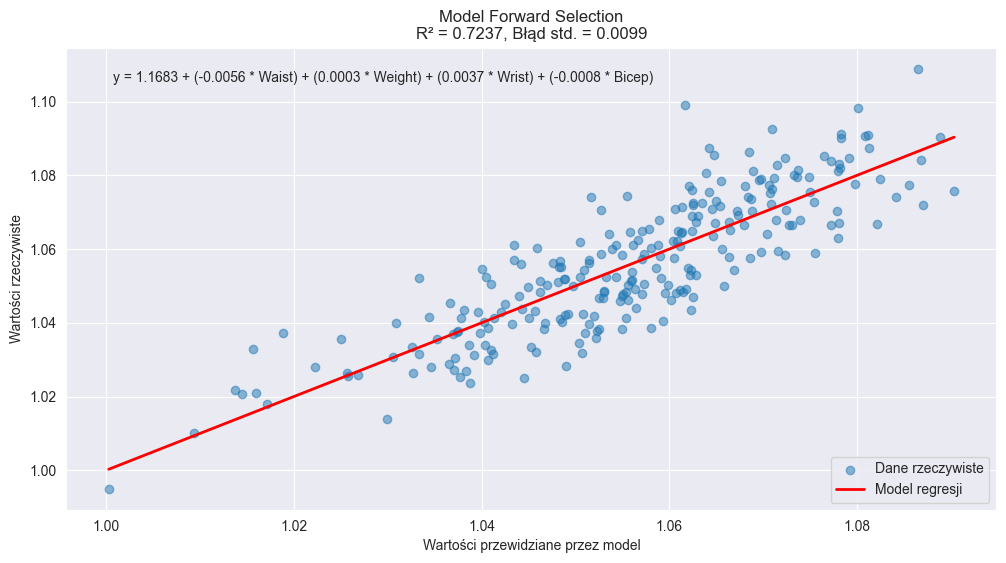


Backward Elimination:
---------------------
Usunięto: Knee (p-value: 0.9177, R²: 0.7389)
Usunięto: Abdomen (p-value: 0.7583, R²: 0.7389)
Usunięto: Weight (p-value: 0.5930, R²: 0.7387)
Usunięto: Ankle (p-value: 0.2359, R²: 0.7384)
Usunięto: Forearm (p-value: 0.1962, R²: 0.7369)
Usunięto: Thigh (p-value: 0.1513, R²: 0.7350)
Usunięto: Hip (p-value: 0.2831, R²: 0.7327)
Usunięto: Neck (p-value: 0.1329, R²: 0.7315)
Usunięto: Bicep (p-value: 0.0559, R²: 0.7289)
Usunięto: Age (p-value: 0.1017, R²: 0.7248)


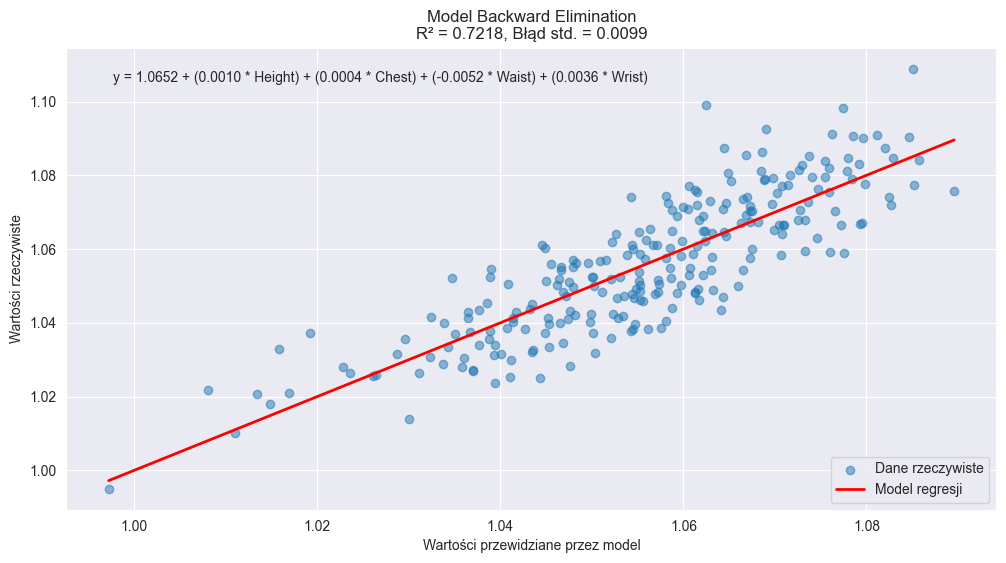


Stepwise Selection:
-------------------
Dodano: Waist (p-value: 0.0000, R²: 0.6545)
Dodano: Weight (p-value: 0.0000, R²: 0.7043)
Dodano: Wrist (p-value: 0.0009, R²: 0.7174)
Dodano: Bicep (p-value: 0.0188, R²: 0.7237)


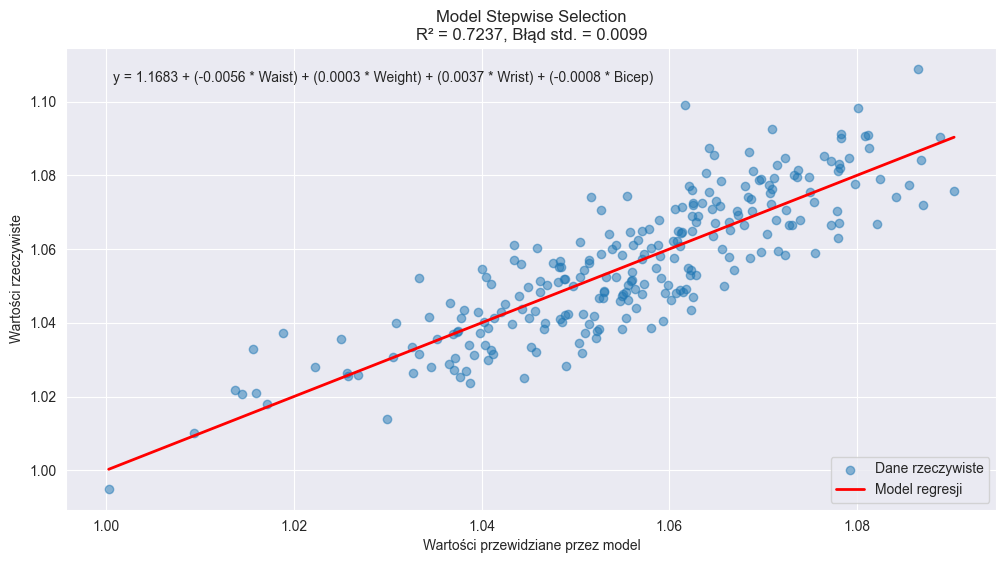

In [19]:
# Używamy dla każdej metody
selector = StepwiseSelector(X, y)

# Forward Selection
forward_features = selector.forward_selection()
visualize_regression_results(X, y, forward_features, "Forward Selection")

# Backward Elimination
backward_features = selector.backward_elimination()
visualize_regression_results(X, y, backward_features, "Backward Elimination")

# Stepwise Selection
stepwise_features = selector.stepwise_selection()
visualize_regression_results(X, y, stepwise_features, "Stepwise Selection")